Author:      Abhijeet Singh

Copyright:   Copyright (©) 2018 EPFL (Ecole Polytechnique Fédérale de Lausanne)
             Geo-Energy lab

# Mesh convergence study for 2D Griffith Crack

Set the Bigwham directory (check on yours)

In [1]:
import os, sys
home = os.environ["HOME"]
sys.path.append(home + "/BigWham/build/interfaces/python")

Import necessary libraries

In [2]:
from hmatrix import Hmatrix
import numpy as np
import math
from scipy.sparse.linalg import gmres
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

Set fontname of matplotlib

In [3]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

Create a function to get displacement values at any point in the solid.

Refer to Weertman - 1996 - Dislocation Based Fracture Mechanics [Fig. 1.8, Eqns. 1.17, 1.18]

In [4]:
def disp_field_griffith(sigma, a, y, x, E, nu):
    
    # sigma is far-field stress
    # a is crack-radius
    # y is y-coordinate of requested displacement field
    # x is x-coordinate of requested displacement field
    # E is Young's modulus
    # nu is Poisson's ratio
    
    theta_c = math.atan2(y,x)
    theta_r = math.atan2(y,x-a)
    theta_l = math.atan2(y,x+a)
    
    R_c = np.sqrt(x**2 + y**2)
    R_r = np.sqrt((x-a)**2 + y**2)
    R_l = np.sqrt((x+a)**2 + y**2)
    
    # Eq 1.18 [Weertman - 1996 - Disloaction Based Fracture Mechanics]
    I = -np.pi*R_c*np.sin(theta_c) + np.pi*np.sqrt(R_l*R_r)*np.sin(0.5*(theta_l+theta_r))
    g = -np.pi*R_c*np.cos(theta_c) + np.pi*np.sqrt(R_l*R_r)*np.cos(0.5*(theta_l+theta_r))
    
    # Shear Modulus
    G = E/(2*(1+nu))
    
    alpha = (1 - nu)
    
    # Eq 1.17 [Weertman - 1996 - Disloaction Based Fracture Mechanics]
    u = (sigma/(2*G))*(((1-2*nu)/np.pi)*g - (R_c**2/np.sqrt(R_l*R_r))*np.sin(theta_c)*np.sin(theta_c - 0.5*theta_r - 0.5*theta_l))
    v = (sigma/(2*G))*((2*alpha/np.pi)*I + R_c*np.sin(theta_c) - (R_c**2/np.sqrt(R_l*R_r))*np.sin(theta_c)*np.cos(theta_c - 0.5*theta_r - 0.5*theta_l ))

    return u, v

H-matrix parameters

In [5]:
max_leaf_size = 16
eta           = 3.0
eps_aca       = 1.e-4

# User Inputs

In [6]:
# Specify kernel for BEM formulation
kernel    = "2DP0"

# Specify material elastic properties
# Young's modulus (in MPa)
E         = 2.e5
# Poisson's ratio
nu        = 0.3
elas_prop = np.array([E, nu])


# Specify stress (in MPa)
sigma   = 1.e2
# Specify crack radius (in mm)
a       = 1.0

# How fine mesh sizes are in comparison to the next largest one
# Always use an odd number except 1 to get results at 
# same colocation points
mesh_factor = 3
# Specify desired mesh size(s)
n_elmts = 50 * mesh_factor**np.linspace(0, 4, 5, dtype = np.int_)

# Specify the number of near tip points needed for stress
# intensity factor mesh convergence study
n_tip = 5
# Matrix to store x-coordinates of near tip points 
# Each column stores data for one mesh size
coords_tip = np.zeros([n_tip, n_elmts.shape[0]])
# Matrix to store y-displacements of near tip points
# Each column stores data for one mesh size
disps_tip  = np.zeros([n_tip, n_elmts.shape[0]])
# Column vector to store stress intensity factor
# for various mesh sizes
K_I        = np.zeros(n_elmts.shape[0])


# x-coordinate where displacement mesh convergence study is needed
x_study = 0 
# Column vector to store y-displacement at that point 
# for various mesh sizes
disp_study = np.zeros(n_elmts.shape[0]) 

# Column vector to store mean L2 error for all mesh sizes
L2_err = np.zeros(n_elmts.shape[0])

Model function for square root curve fitting

In [7]:
# Define the model function for curve fitting
def model_function(x, k):
    return k * np.sqrt(x)

Other factors needed for later computations

In [ ]:
# Plane Strain factor
alpha = 1 - nu
# Shear Modulus
G = E/(2*(1+nu))
# The constant that acts as a proportionality constant while approximating K_I
const = 2*alpha/(G*np.sqrt(np.pi*a))

# Solve the problem for various mesh sizes

In [8]:
# Solve the problem to get displacements for each mesh size
for i in range(n_elmts.shape[0]):

    # Get coordinates and connectivity matrix
    coord1D = np.linspace(-a, a, n_elmts[i] + 1)
    coord   = np.transpose(np.array([coord1D, coord1D * 0.0]))
    conn    = np.fromfunction(lambda x, y: x + y, (n_elmts[i], 2), dtype=np.int_)

    # Get HMatrix
    H       = Hmatrix(kernel, coord, conn, elas_prop, max_leaf_size, eta, eps_aca)

    # Get mesh collocation points
    col_pts = H.getMeshCollocationPoints()
    
    # Make a traction vector to assign traction
    trac       = np.zeros(col_pts.shape)
    trac[:, 1] = sigma

    # Get displacements using traction vector
    # Convert traction to local co-ordinates
    u, info = gmres(H, H.convert_to_local(trac.flatten()))
    # Obtain displacements by converting to global co-ordinates
    disp    = (H.convert_to_global(u)).reshape(-1,2)
    # Obtain theoretical y-displacement at those points
    disp_th = np.array([2*output for _, output in (disp_field_griffith(sigma, a, 0.0, col_pts[x,0], E, nu) for x in range(col_pts.shape[0]))])

    # Compute mean L2 error for the specified mesh size
    L2_err[i] = np.linalg.norm(disp[:,1] - disp_th) / np.sqrt(col_pts.shape[0])


    # For loop to store information at requested x-coordinates near the tip of crack
    for j in range(n_tip):
        # Get the index of the required crack tip neighbourhood point
        index = (n_elmts[i] - 1) - ((mesh_factor**i // 2) + j*(mesh_factor**i))
        # Get the x-coordinate of that point using the index
        coords_tip[j,i] = col_pts[index, 0]
        # Get the y-displacement of that point using the index
        disps_tip[j,i]  = disp[index, 1]

    idx_tip_study = np.where(coord[:, 0] == x_study)
    # Get the displacement for mesh convergence study
    disp_study[i] = disp[idx_tip_study,1]    
    # Do curve fitting to later get the stress intensity factor
    params, covariance = curve_fit(model_function, a**2 - coords_tip[:,i]**2, disps_tip[:,i])
    # Get the stress intensity factor   
    K_I[i] = params[0]/const

# Specify the same tip co-ordinates used previously to get analytical displacements
coords_tip_th = coords_tip[:,0]
# Get the analytical displacements
disp_tip_th   = np.array([2*output for _, output in (disp_field_griffith(sigma, a, 0.0, coords_tip_th[x], E, nu) for x in range(coords_tip_th.shape[0]))])
# Do curve fitting to later get the analytical stress intensity factor
params, covariance = curve_fit(model_function, a**2 - coords_tip_th**2, disp_tip_th)
# Get the analytical intensity factor
K_I_th    = params[0]/const  
# Obtain the relative error in stress intensity factor for each mesh size
rel_err = np.abs(K_I - K_I_th)/K_I_th


# Get the analytical displacement at the point chosen for displacement 
# mesh convergence study
result = disp_field_griffith(sigma, a, 0.0, x_study, E, nu)
disp_study_th = result[1]*2

 Now setting things for kernel ... 2DP0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  2.0299e-05
Binary cluster tree depth = 2
Number of blocks = 16
Number of full blocks = 10
Number of low rank blocks = 6
Pattern Created 
 Loop on full blocks construction  
 N full blocks 10 
Loop on low rank blocks construction
N low rank blocks 6
dof_dimension: 2
Creation of hmat done in 0.00460355
Compression ratio - 0.8856
Hmat object - built 
HMAT --> built 
HMAT set, CR = 0.8856, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED
 Now setting things for kernel ... 2DP0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  6.2434e-05
Binary cluster tree depth = 4
Number of blocks = 112
Number of full blocks = 46
Number of low rank blocks = 66
Pattern Created 
 Loop on full blocks construction  
 N full blocks 46 
Loop on low rank blocks construction
N low rank blocks 66
dof_dimension: 2
Creation of hmat done in

# Plot of y-displacement v/s x-coordinates near tip

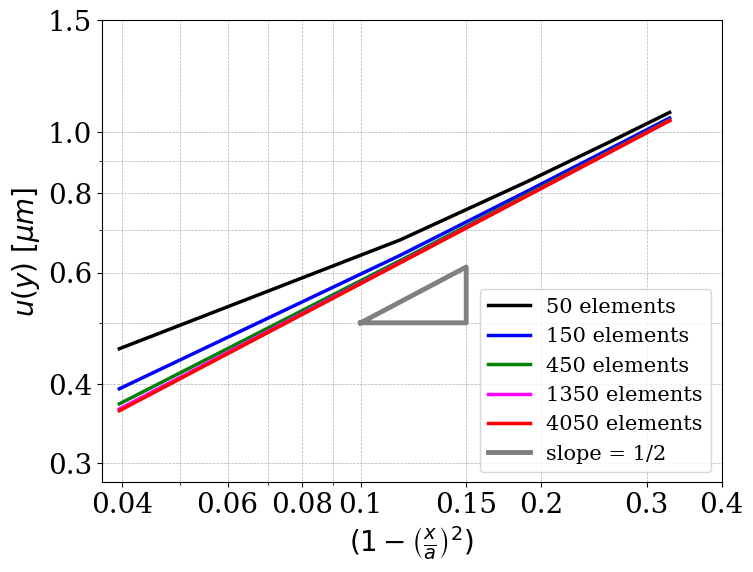

In [9]:
# Specify points for 1/2 slope on log-log plot
x1 = 0.1
x2 = 0.15
y1 = 0.5
y2 = 0.6123

plt.figure(figsize=(8, 6))
# Create the plot
plt.loglog((1 - (coords_tip[:,0]/a)**2)*1e0, (disps_tip[:,0])*1e3, color = 'black',   linewidth = 2.5, label=f'{n_elmts[0]} elements')
plt.loglog((1 - (coords_tip[:,1]/a)**2)*1e0, (disps_tip[:,1])*1e3, color = 'blue',    linewidth = 2.5, label=f'{n_elmts[1]} elements')
plt.loglog((1 - (coords_tip[:,2]/a)**2)*1e0, (disps_tip[:,2])*1e3, color = 'green',   linewidth = 2.5, label=f'{n_elmts[2]} elements')
plt.loglog((1 - (coords_tip[:,3]/a)**2)*1e0, (disps_tip[:,3])*1e3, color = 'magenta', linewidth = 2.5, label=f'{n_elmts[3]} elements')
plt.loglog((1 - (coords_tip[:,4]/a)**2)*1e0, (disps_tip[:,4])*1e3, color = 'red',     linewidth = 2.5, label=f'{n_elmts[4]} elements')
# plt.loglog((1 - (coords_tip_th/a)**2)*1e2      , (disp_tip_th)*1e3,        color = 'gray',    marker='*', linestyle='None', markersize=10, label=f'Analytical')
plt.loglog([x1, x2, x2, x1], [y1, y1, y2, y1], color = 'gray', linewidth = 3.5, label=f'slope = 1/2')

# Add labels with LaTeX formatting
plt.xlabel(r'$(1 - \left(\frac{x}{a}\right)^2)$', fontsize=20)
plt.ylabel(r'$u(y)$ $[\mu m]$', fontsize=20)
# plt.title(r'Plot for $x/a > 0.8$', loc='center', fontsize=15)
# Increase the size of x and y labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Specify x and y limits with a specified number of ticks
plt.xlim(0.037, 0.4)  # x limits
plt.ylim(0.28, 1.5)       # y limits
# Specify x-ticks and y-ticks
x_ticks = [0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4]
y_ticks = [0.3, 0.4, 0.6, 0.8, 1.0, 1.5]

# Set x-ticks and y-ticks
plt.xticks(x_ticks, [str(tick) for tick in x_ticks])
plt.yticks(y_ticks, [str(tick) for tick in y_ticks])
# Turn grid lines on
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='lower right', fontsize=15)

# Uncomment below lines to save image files
# # Create a subfolder if it doesn't exist
# os.makedirs('images', exist_ok=True)

# # Save the plot in PNG, JPG, and EPS formats
# plt.savefig('images/griffith_stress_intensity_mesh_size.png', dpi=300, bbox_inches='tight')
# plt.savefig('images/griffith_stress_intensity_mesh_size.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('images/griffith_stress_intensity_mesh_size.eps', format='eps', dpi=300, bbox_inches='tight')

# Plot of relative error of stress intensity factor v/s mesh size

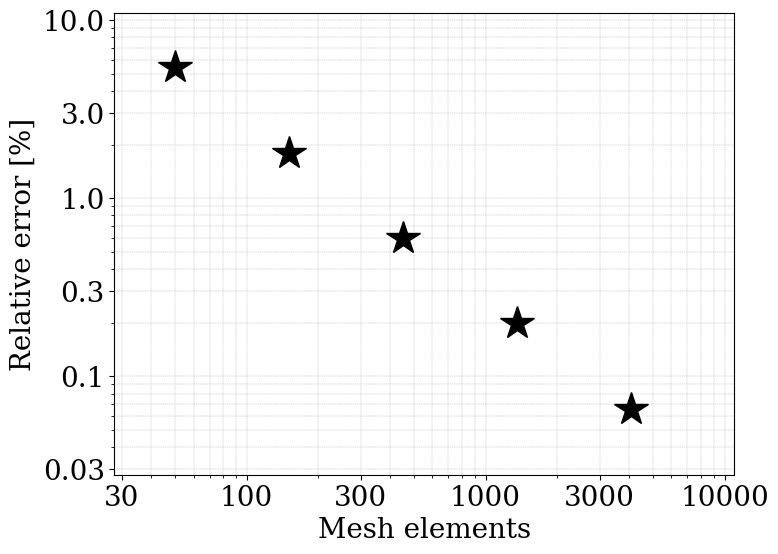

In [10]:
plt.figure(figsize=(8, 6))
# Create the plot
plt.loglog(n_elmts, rel_err*1e2, color = 'black', marker='*', linestyle='None', markersize=25)

# Add labels with LaTeX formatting
plt.xlabel(r'Mesh elements', fontsize=20)
plt.ylabel(r'Relative error [%]', fontsize=20)
# Increase the size of x and y labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# # Specify x and y limits with a specified number of ticks
plt.xlim(2.8e1, 1.1e4)  # x limits
plt.ylim(2.8e-2, 1.1e1)       # y limits

# Specify x-ticks and y-ticks
x_ticks = [30, 100, 300, 1000, 3000, 10000]
y_ticks = [0.03, 0.1, 0.3, 1.0, 3.0, 10.0]

# Set x-ticks and y-ticks
plt.xticks(x_ticks, [str(tick) for tick in x_ticks])
plt.yticks(y_ticks, [str(tick) for tick in y_ticks])
# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

# Uncomment below lines to save image files
# # Create a subfolder if it doesn't exist
# os.makedirs('images', exist_ok=True)

# # Save the plot in PNG, JPG, and EPS formats
# plt.savefig('images/griffith_rel_error_mesh_size.png', dpi=300, bbox_inches='tight')
# plt.savefig('images/griffith_rel_error_mesh_size.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('images/griffith_rel_error_mesh_size.eps', format='eps', dpi=300, bbox_inches='tight')

# Plot of relative error of y-displacement at x = 0 v/s mesh size

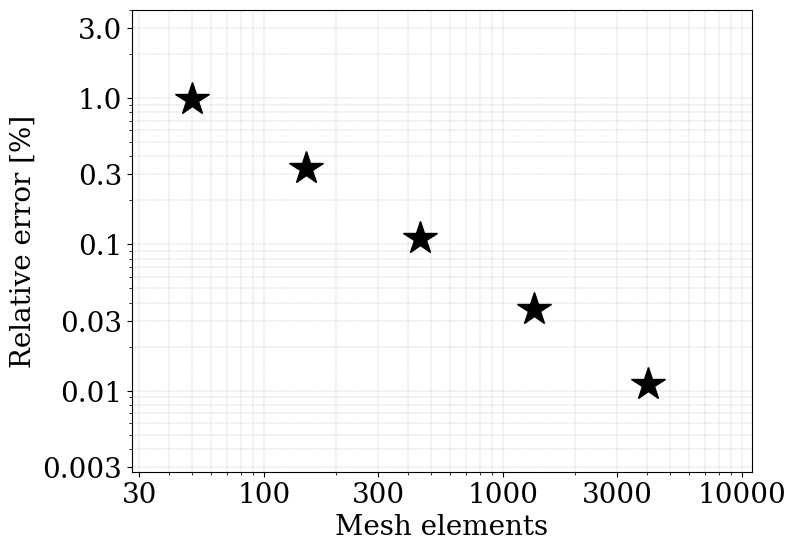

In [11]:
plt.figure(figsize=(8, 6))
# Create the plot
plt.loglog(n_elmts, np.abs((disp_study - disp_study_th)/(disp_study_th))*1e2, color = 'black', marker='*', linestyle='None', markersize=25)


# Add labels with LaTeX formatting
plt.xlabel(r'Mesh elements', fontsize=20)
plt.ylabel(r'Relative error [%]', fontsize=20)
# plt.title(r'Error in calculating Stress Intensity Factor for various mesh sizes', loc='center', fontsize=15)
# Increase the size of x and y labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# # Specify x and y limits with a specified number of ticks
plt.xlim(2.8e1, 1.1e4)  # x limits
plt.ylim(2.8e-3, 4e0)       # y limits

# Specify x-ticks and y-ticks
x_ticks = [30, 100, 300, 1000, 3000, 10000]
y_ticks = [0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]

# Set x-ticks and y-ticks
plt.xticks(x_ticks, [str(tick) for tick in x_ticks])
plt.yticks(y_ticks, [str(tick) for tick in y_ticks])
# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

# Uncomment below lines to save image files
# # Create a subfolder if it doesn't exist
# os.makedirs('images', exist_ok=True)

# # Save the plot in PNG, JPG, and EPS formats
# plt.savefig('images/disp_rel_error_mesh_size.png', dpi=300, bbox_inches='tight')
# plt.savefig('images/disp_rel_error_mesh_size.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('images/disp_rel_error_mesh_size.eps', format='eps', dpi=300, bbox_inches='tight')

# Plot of RMS error of y-diplacement values at all colocation points v/s mesh size

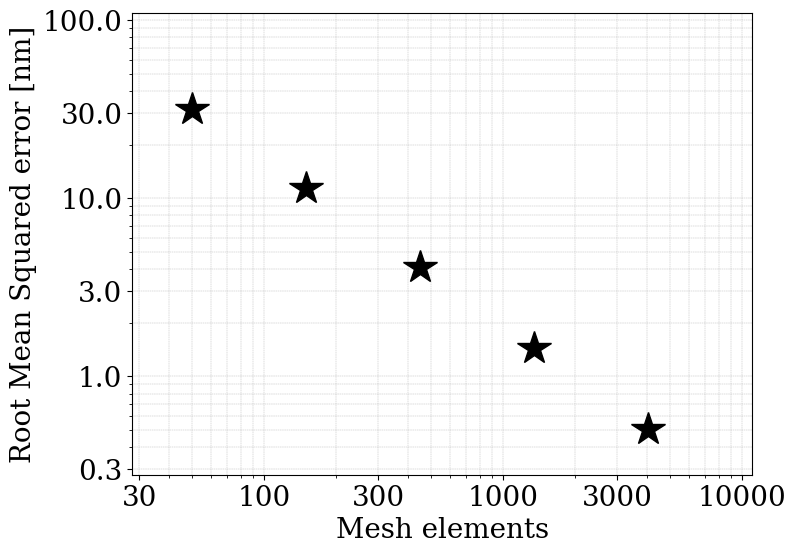

In [12]:
plt.figure(figsize=(8, 6))
# Create the plot
plt.loglog(n_elmts, L2_err*1e6, color = 'black', marker='*', linestyle='None', markersize=25)

# Add labels with LaTeX formatting
plt.xlabel(r'Mesh elements', fontsize=20)
plt.ylabel(r'Root Mean Squared error [nm]', fontsize=20)
# plt.title(r'Error in calculating Stress Intensity Factor for various mesh sizes', loc='center', fontsize=15)
# Increase the size of x and y labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# # Specify x and y limits with a specified number of ticks
plt.xlim(2.8e1, 1.1e4)  # x limits
plt.ylim(2.8e-1, 1.1e2)       # y limits

# Specify x-ticks and y-ticks
x_ticks = [30, 100, 300, 1000, 3000, 10000]
y_ticks = [0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

# Set x-ticks and y-ticks
plt.xticks(x_ticks, [str(tick) for tick in x_ticks])
plt.yticks(y_ticks, [str(tick) for tick in y_ticks])
# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.3)

# Uncomment below lines to save image files
# # Create a subfolder if it doesn't exist
# os.makedirs('images', exist_ok=True)

# # Save the plot in PNG, JPG, and EPS formats
# plt.savefig('images/mean_L2_error_mesh_size.png', dpi=300, bbox_inches='tight')
# plt.savefig('images/mean_L2_error_mesh_size.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('images/mean_L2_error_mesh_size.eps', format='eps', dpi=300, bbox_inches='tight')